In [2]:
# inspired from https://github.com/danieleds/Reservoir-Computing-in-PyTorch/blob/master/ESN/esn.py
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import seaborn
import sys
seaborn.set()

import warnings
warnings.filterwarnings("ignore")

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
device

device(type='cuda')

# Define functions

### Echo State Network

In [4]:
class ESN(torch.nn.Module):
    """
    Implements an Echo State Network.
    Parameters:
      - input_size: size of the input
      - reservoir_size: number of units in the reservoir
      - scale_in: scaling of the input-to-reservoir matrix
      - f: activation function for the state transition function
    """

    def __init__(self, input_size, reservoir_size, bias =0,
                 scale_in=1.0, scale_res=1.0, f='erf', redraw=False):
        super(ESN, self).__init__()

        self.input_size = input_size
        self.reservoir_size = reservoir_size
        self.scale_in = scale_in
        self.scale_res = scale_res
        self.bias = bias
        if f == 'erf':
            self.f = torch.erf
        if f == 'cos_rbf':
            self.f = lambda x : np.sqrt(2)*torch.cos(x + self.bias).to(device)
        if f == 'heaviside':
            self.f = lambda x: 1 * (x > 0)
        if f == 'sign':
            self.f = torch.sign
                
        #self.f = f
        
        self.redraw = redraw
        
        torch.manual_seed(1)
        self.W_in = torch.randn(reservoir_size, input_size).to(device)
        self.W_res = torch.randn(reservoir_size, reservoir_size).to(device)
        
    def forward(self, input_data, initial_state=None):
        """
        Compute the reservoir states for the given sequence.
        Parameters:
          - input: Input sequence of shape (seq_len, input_size), i.e. (t,d)
        
        Returns: a tensor of shape (seq_len, reservoir_size)
        """
        x = torch.zeros((input_data.shape[0], self.reservoir_size), device=self.W_res.device)

        if initial_state is not None:
            x[0,:] = self.f( self.scale_in * torch.matmul(self.W_in, input_data[0,:]) +
                            self.scale_res * torch.matmul(self.W_res, initial_state) ) / np.sqrt(self.reservoir_size)
        else:
            x[0,:] = self.f( self.scale_in * torch.matmul(self.W_in, input_data[0,:]) ) / np.sqrt(self.reservoir_size)
        
        # I made an important change here, i needs to start at 1 since the first step has been computed already
        for i in range(1, input_data.shape[0]):
            if self.redraw == True:
                torch.manual_seed(i)
                W_inn = self.scale_in*torch.randn((self.reservoir_size, self.input_size)).to(device)
                W_ress = self.scale_res*torch.randn((self.reservoir_size, self.reservoir_size)).to(device)/np.sqrt(self.reservoir_size)
                x[i,:] = self.f( self.scale_in * torch.matmul(W_inn, input_data[i,:]) + 
                                self.scale_res * torch.matmul(W_ress, x[i-1]) ) / np.sqrt(self.reservoir_size)
            else:
                x[i,:] = self.f( self.scale_in * torch.matmul(self.W_in, input_data[i,:]) + 
                                self.scale_res * torch.matmul(self.W_res, x[i-1]) ) / np.sqrt(self.reservoir_size)
        
        return x

### Kernel functions

In [5]:
def compute_arcsin_kernel(input_data, initial_state,scale_res,scale_in = 1):
    n_input = input_data.shape[0]
    input_len = input_data.shape[1]
    input_dim = input_data.shape[2]
    n_res = initial_state.shape[0]
    
    K = torch.ones((n_input,n_input)).to(device) * torch.norm(initial_state)
    for t in range(input_len):
        current_input = input_data[:,t,:].reshape(n_input,input_dim)
        input_gram = torch.matmul(current_input, current_input.t())
        
        diag_res = torch.diag(K)
        diag_in = torch.diag(input_gram)
        renorm_diag = 1 /(1+2*(scale_res**2)*diag_res +2*(scale_in)**2 *diag_in)
        renorm_factor = torch.sqrt(torch.matmul(renorm_diag.reshape(n_input, 1), renorm_diag.reshape(1, n_input)))
        K = torch.asin(2 * ((scale_res**2)*K + (scale_in**2) *input_gram) * renorm_factor) * 2 / np.pi
    return K.to(device)

In [77]:
def compute_rbf_kernel(input_data, initial_state,scale_res,scale_in = 1):
    n_input = input_data.shape[0]
    input_len = input_data.shape[1]
    input_dim = input_data.shape[2]
    n_res = initial_state.shape[0]
    
    K = torch.ones((n_input,n_input)).to(device) * torch.norm(initial_state)
    for t in range(input_len):
        current_input = input_data[:,t,:].reshape(n_input,input_dim)
        input_gram = torch.matmul(current_input, current_input.t())
        
        diag_res = torch.diag(K) #x**2
        diag_in = torch.diag(input_gram) #i**2

        K = torch.exp(-0.5*(diag_res.reshape(n_input,1))*scale_res**2)\
            *torch.exp(-0.5*(diag_res.reshape(1,n_input))*scale_res**2)\
                *torch.exp(K*scale_res**2)\
                    * torch.exp(- 0.5*torch.cdist(current_input,current_input)**2 *scale_in**2)
    return K.to(device)

In [7]:
def compute_acos_heaviside_kernel(input_data, initial_state,scale_res,scale_in = 1):
    n_input = input_data.shape[0]
    input_len = input_data.shape[1]
    input_dim = input_data.shape[2]
    n_res = initial_state.shape[0]
    
    K = torch.ones((n_input,n_input)).to(device) * torch.norm(initial_state)
    for t in range(input_len):
        current_input = input_data[:,t,:].reshape(n_input,input_dim)
        input_gram = torch.matmul(current_input, current_input.t())
        
        diag_res = torch.diag(K)
        diag_in = torch.diag(input_gram)
        renorm_diag = 1 /((scale_res**2)*diag_res + (scale_in)**2 * diag_in)
        renorm_factor = torch.sqrt(torch.matmul(renorm_diag.reshape(n_input, 1), renorm_diag.reshape(1, n_input)))
        K = 0.5 - torch.acos(((scale_res**2)*K + (scale_in**2) *input_gram) * renorm_factor) /(2*np.pi) 
    return K.to(device)

In [8]:
def compute_asin_sign_kernel(input_data, initial_state,scale_res,scale_in = 1):
    n_input = input_data.shape[0]
    input_len = input_data.shape[1]
    input_dim = input_data.shape[2]
    n_res = initial_state.shape[0]
    
    K = torch.ones((n_input,n_input)).to(device) * torch.norm(initial_state)
    for t in range(input_len):
        current_input = input_data[:,t,:].reshape(n_input,input_dim)
        input_gram = torch.matmul(current_input, current_input.t())
        
        diag_res = torch.diag(K)
        diag_in = torch.diag(input_gram)
        renorm_diag = 1 /((scale_res**2)*diag_res + (scale_in)**2 * diag_in)
        renorm_factor = torch.sqrt(torch.matmul(renorm_diag.reshape(n_input, 1), renorm_diag.reshape(1, n_input)))
        K = (2/np.pi)*torch.asin(((scale_res**2)*K + (scale_in**2) *input_gram) * renorm_factor)  
    return K.to(device)

## Kuramoto-Sivashinsky equation

In [9]:
# KSequ.m - solution of Kuramoto-Sivashinsky equation
# https://github.com/E-Renshaw/kuramoto-sivashinsky/blob/master/ksequ.py

# u_t = -u*u_x - u_xx - u_xxxx, periodic boundary conditions on [0,32*pi]
# computation is based on v = fft(u), so linear term is diagonal
#
# Using this program:
# u is the initial condition / maybe add randomness
# h is the time step
# N is the number of points calculated along x = L de Wikipedia / N =100 le nb de points sur l'axe des x = input_dim
# a is the max value in the initial condition
# b is the min value in the initial condition
# x is used when using a periodic boundary condition, to set up in terms of pi
#
# Initial condition and grid setup

def kuramoto(N , tmax = 100): 
    N = N
    x = np.transpose(np.conj(np.arange(1, N+1))) / N
    a = -1
    b = 1
    #u = np.cos(x/16)*(1+np.sin(x/16)) # + add random phase in sinus between 0 and 2pi
    #u = np.random.randn(1)
    u = np.cos((1+np.random.uniform(0,1))*x/16+np.random.uniform(0,2*np.pi))#*(1+np.sin(1+np.random.uniform(0,1)*x/16+np.random.uniform(0,2*np.pi)))
    v = np.fft.fft(u)
# scalars for ETDRK4
    h = 1#0.25 time step
    k = np.transpose(np.conj(np.concatenate((np.arange(0, N/2), np.array([0]), np.arange(-N/2+1, 0))))) / 16
    L = k**2 - k**4
    E = np.exp(h*L)
    E_2 = np.exp(h*L/2)
    M = 16
    r = np.exp(1j*np.pi*(np.arange(1, M+1)-0.5) / M)
    LR = h*np.transpose(np.repeat([L], M, axis=0)) + np.repeat([r], N, axis=0)
    Q = h*np.real(np.mean((np.exp(LR/2)-1)/LR, axis=1))
    f1 = h*np.real(np.mean((-4-LR+np.exp(LR)*(4-3*LR+LR**2))/LR**3, axis=1))
    f2 = h*np.real(np.mean((2+LR+np.exp(LR)*(-2+LR))/LR**3, axis=1))
    f3 = h*np.real(np.mean((-4-3*LR-LR**2+np.exp(LR)*(4-LR))/LR**3, axis=1))
# main loop
    uu = np.array([u])
    tt = 0
    tmax = tmax#150
    nmax = round(tmax/h)
    nplt = int((tmax/100)/h)
    g = -0.5j*k
    for n in range(1,nmax):
        t = n*h
        Nv = g*np.fft.fft(np.real(np.fft.ifft(v))**2)
        a = E_2*v + Q*Nv
        Na = g*np.fft.fft(np.real(np.fft.ifft(a))**2)
        b = E_2*v + Q*Na
        Nb = g*np.fft.fft(np.real(np.fft.ifft(b))**2)
        c = E_2*a + Q*(2*Nb-Nv)
        Nc = g*np.fft.fft(np.real(np.fft.ifft(c))**2)
        v = E*v + Nv*f1 + 2*(Na+Nb)*f2 + Nc*f3
        #if n%nplt == 0:
        u = np.real(np.fft.ifft(v))
        uu = np.append(uu, np.array([u]), axis=0)
        tt = np.hstack((tt, t))
    return uu

## Generation of normalized random gaussian data

In [10]:
def gaussian_data(n_input, input_len_max, input_dim,fix_seed= False):
    if fix_seed == True:
        torch.manual_seed(42)
    return torch.randn(n_input, input_len_max, input_dim).to(device) / np.sqrt(input_dim)

# Sanity check to compare the Kernel Matrix and the Gram Matrix

### Gaussian random data

In [11]:
#arcsin kernel

n_input = 50 # number of time series
input_len = 40 # time steps t
input_dim = 100 #dimension of the time series
scale_in = 1  # variance of input
scale_res = 1 # variance of reservoir

torch.manual_seed(123)
input_data = gaussian_data(n_input, input_len, input_dim)

loss = torch.nn.MSELoss()

n_res_range = np.arange(start=100,stop=10000, step=1000)
error_gauss_asin = torch.zeros(len(n_res_range))

for i, n_res in tqdm(enumerate(n_res_range)):
    initial_state = torch.randn(n_res).to(device) / np.sqrt(n_res)
    K = compute_arcsin_kernel(input_data, initial_state, scale_res)
    X_final = torch.zeros((n_input,n_res)).to(device)
    for n_in in range(n_input):
        model = ESN(input_dim, reservoir_size=n_res, scale_res = scale_res, scale_in = scale_in,f='erf')
        X = model.forward(input_data[n_in,:,:].reshape(input_len,input_dim), initial_state = initial_state).to(device)
        X_final[n_in,:] = X[-1,:]
    
    K_hat = torch.matmul(X_final,X_final.t())
    error_gauss_asin[i] = loss(K_hat,K) / loss(K, torch.zeros(n_input, n_input).to(device))

10it [02:10, 23.50s/it]


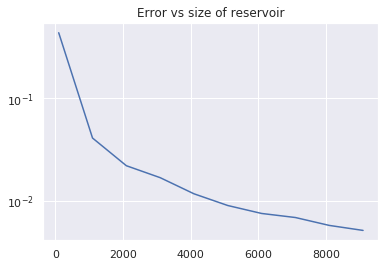

In [12]:
plt.semilogy(n_res_range, error_gauss_asin.numpy())
plt.title('Error vs size of reservoir');

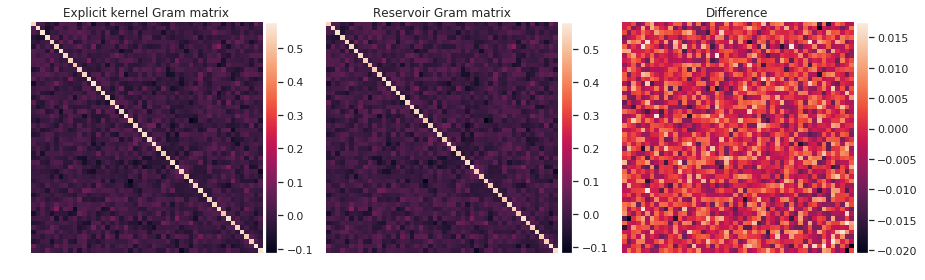

In [13]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
_, axes  = plt.subplots(1, 3, figsize=(15, 6))

plot = axes[0].imshow(K.cpu().numpy())
axes[0].axis("off")
axes[0].set_title("Explicit kernel Gram matrix")
divider = make_axes_locatable(axes[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(plot, cax=cax)

plot = axes[1].imshow(K_hat.cpu().numpy())
axes[1].axis("off")
axes[1].set_title("Reservoir Gram matrix")
divider = make_axes_locatable(axes[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(plot, cax=cax)

plot = axes[2].imshow((K-K_hat).cpu().numpy())
axes[2].axis("off")
axes[2].set_title("Difference")
divider = make_axes_locatable(axes[2])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(plot, cax=cax);

In [78]:
#rbf kernel

n_input = 50 # number of time series
input_len = 40 # time steps t
input_dim = 100 #dimension of the time series
scale_in = 1  # variance of input
scale_res = 0.01 # variance of reservoir

torch.manual_seed(123)
input_data = gaussian_data(n_input, input_len, input_dim)
loss = torch.nn.MSELoss()

n_res_range = np.arange(start=100,stop=10000, step=1000)
error_gauss_rbf = torch.zeros(len(n_res_range))

for i, n_res in tqdm(enumerate(n_res_range)):
    initial_state = torch.randn(n_res).to(device) / np.sqrt(n_res)
    K = compute_rbf_kernel(input_data, initial_state, scale_res)
    X_final = torch.zeros((n_input,n_res)).to(device)
    
    torch.manual_seed(i)
    bias = torch.Tensor(np.random.uniform(0,2*np.pi, size=n_res)).to(device)
    for n_in in range(n_input):
        model = ESN(input_dim, reservoir_size=n_res, bias = bias, scale_res = scale_res,\
                    scale_in = scale_in, \
                    f='cos_rbf')
        X = model.forward(input_data[n_in,:,:].reshape(input_len,input_dim), initial_state = initial_state).to(device)
        X_final[n_in,:] = X[-1,:]
    
    K_hat = torch.matmul(X_final,X_final.t())
    error_gauss_rbf[i] = loss(K_hat,K)/ loss(K, torch.zeros(n_input, n_input).to(device))

10it [02:14, 24.02s/it]


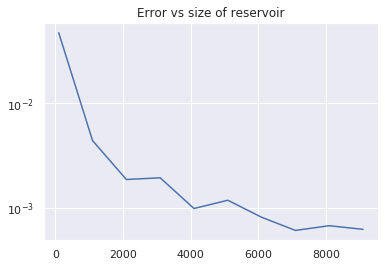

In [79]:
plt.semilogy(n_res_range, error_gauss_rbf.numpy())
plt.title('Error vs size of reservoir');

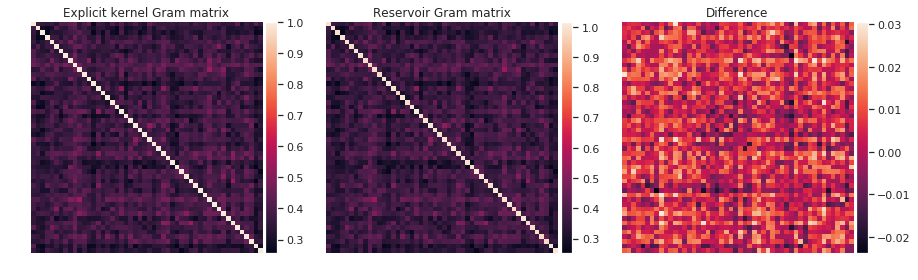

In [80]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
_, axes  = plt.subplots(1, 3, figsize=(15, 6))

plot = axes[0].imshow(K.cpu().numpy())
axes[0].axis("off")
axes[0].set_title("Explicit kernel Gram matrix")
divider = make_axes_locatable(axes[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(plot, cax=cax)

plot = axes[1].imshow(K_hat.cpu().numpy())
axes[1].axis("off")
axes[1].set_title("Reservoir Gram matrix")
divider = make_axes_locatable(axes[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(plot, cax=cax)

plot = axes[2].imshow((K-K_hat).cpu().numpy())
axes[2].axis("off")
axes[2].set_title("Difference")
divider = make_axes_locatable(axes[2])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(plot, cax=cax);

In [17]:
#arcos_heaviside kernel

n_input = 50 # number of time series
input_len = 40 # time steps t
input_dim = 100 #dimension of the time series
scale_in = 1  # variance of input
scale_res = 1 # variance of reservoir

torch.manual_seed(123)
input_data = gaussian_data(n_input, input_len, input_dim)

loss = torch.nn.MSELoss()

n_res_range = np.arange(start=100,stop=10000, step=1000)
error_gauss_acos_heaviside = torch.zeros(len(n_res_range))

for i, n_res in tqdm(enumerate(n_res_range)):
    initial_state = torch.randn(n_res).to(device) / np.sqrt(n_res)
    K = compute_acos_heaviside_kernel(input_data, initial_state, scale_res)
    X_final = torch.zeros((n_input,n_res)).to(device)
    for n_in in range(n_input):
        model = ESN(input_dim, reservoir_size=n_res, scale_res = scale_res, scale_in = scale_in, f='heaviside')
        X = model.forward(input_data[n_in,:,:].reshape(input_len,input_dim), initial_state = initial_state).to(device)
        X_final[n_in,:] = X[-1,:]
    
    K_hat = torch.matmul(X_final,X_final.t())
    error_gauss_acos_heaviside[i] = loss(K_hat,K) / loss(K, torch.zeros(n_input, n_input).to(device))

10it [02:29, 25.11s/it]


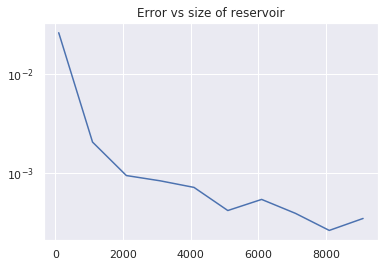

In [18]:
plt.semilogy(n_res_range, error_gauss_acos_heaviside.numpy())
plt.title('Error vs size of reservoir');

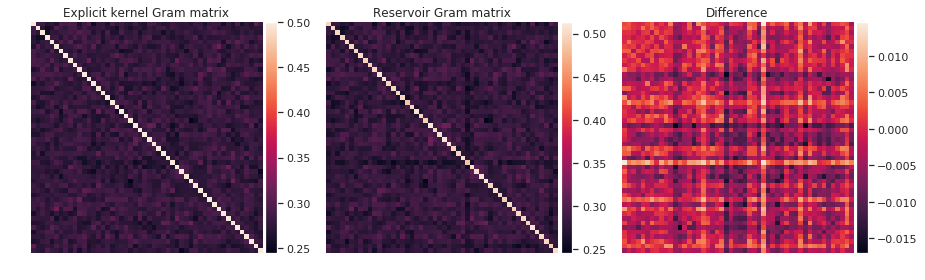

In [19]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
_, axes  = plt.subplots(1, 3, figsize=(15, 6))

plot = axes[0].imshow(K.cpu().numpy())
axes[0].axis("off")
axes[0].set_title("Explicit kernel Gram matrix")
divider = make_axes_locatable(axes[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(plot, cax=cax)

plot = axes[1].imshow(K_hat.cpu().numpy())
axes[1].axis("off")
axes[1].set_title("Reservoir Gram matrix")
divider = make_axes_locatable(axes[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(plot, cax=cax)

plot = axes[2].imshow((K-K_hat).cpu().numpy())
axes[2].axis("off")
axes[2].set_title("Difference")
divider = make_axes_locatable(axes[2])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(plot, cax=cax);

In [20]:
#asin_sign kernel

n_input = 50 # number of time series
input_len = 40 # time steps t
input_dim = 100 #dimension of the time series
scale_in = 1  # variance of input
scale_res = 1 # variance of reservoir

torch.manual_seed(123)
input_data = gaussian_data(n_input, input_len, input_dim)

loss = torch.nn.MSELoss()

n_res_range = np.arange(start=100,stop=10000, step=1000)
error_gauss_asin_sign = torch.zeros(len(n_res_range))

for i, n_res in tqdm(enumerate(n_res_range)):
    initial_state = torch.randn(n_res).to(device) / np.sqrt(n_res)
    K = compute_asin_sign_kernel(input_data, initial_state, scale_res)
    X_final = torch.zeros((n_input,n_res)).to(device)
    for n_in in range(n_input):
        model = ESN(input_dim, reservoir_size=n_res, scale_res = scale_res, scale_in = scale_in, f='sign')
        X = model.forward(input_data[n_in,:,:].reshape(input_len,input_dim), initial_state = initial_state).to(device)
        X_final[n_in,:] = X[-1,:]
    
    K_hat = torch.matmul(X_final,X_final.t())
    error_gauss_asin_sign[i] = loss(K_hat,K) / loss(K, torch.zeros(n_input, n_input).to(device))

10it [02:10, 23.50s/it]


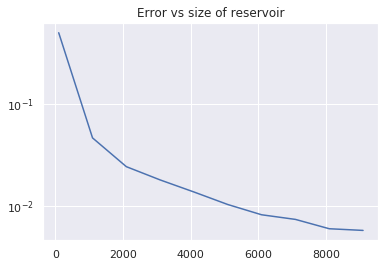

In [21]:
plt.semilogy(n_res_range, error_gauss_asin_sign.numpy())
plt.title('Error vs size of reservoir');

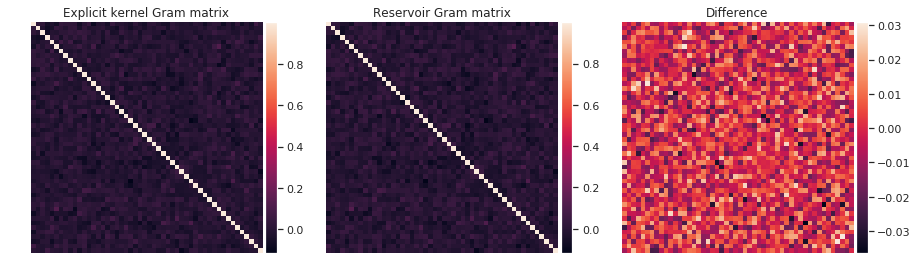

In [22]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
_, axes  = plt.subplots(1, 3, figsize=(15, 6))

plot = axes[0].imshow(K.cpu().numpy())
axes[0].axis("off")
axes[0].set_title("Explicit kernel Gram matrix")
divider = make_axes_locatable(axes[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(plot, cax=cax)

plot = axes[1].imshow(K_hat.cpu().numpy())
axes[1].axis("off")
axes[1].set_title("Reservoir Gram matrix")
divider = make_axes_locatable(axes[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(plot, cax=cax)

plot = axes[2].imshow((K-K_hat).cpu().numpy())
axes[2].axis("off")
axes[2].set_title("Difference")
divider = make_axes_locatable(axes[2])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(plot, cax=cax);

### Kuramoto data

In [23]:
#arcsin kernel

n_input = 50 # number of time series
input_len = 40 # time steps t
input_dim = 100 #dimension of the time series
scale_in = 1  # variance of input
scale_res = 1 # variance of reservoir

input_data = torch.zeros(n_input, input_len, input_dim).to(device)
for n_inp in range(n_input):
    input_data[n_inp,:,:] = torch.Tensor(kuramoto(input_dim, input_len))/np.sqrt(input_dim)

loss = torch.nn.MSELoss()

n_res_range = np.arange(start=100,stop=10000, step=1000)
error_kura_asin = torch.zeros(len(n_res_range))

for i, n_res in tqdm(enumerate(n_res_range)):
    initial_state = torch.randn(n_res).to(device) / np.sqrt(n_res)
    K = compute_arcsin_kernel(input_data, initial_state, scale_res)
    X_final = torch.zeros((n_input,n_res)).to(device)
    for n_in in range(n_input):
        model = ESN(input_dim, reservoir_size=n_res, scale_res = scale_res, scale_in = scale_in,f='erf')
        X = model.forward(input_data[n_in,:,:].reshape(input_len,input_dim), initial_state = initial_state).to(device)
        X_final[n_in,:] = X[-1,:]
    
    K_hat = torch.matmul(X_final,X_final.t())
    error_kura_asin[i] = loss(K_hat,K) / loss(K, torch.zeros(n_input, n_input).to(device))

10it [02:11, 23.53s/it]


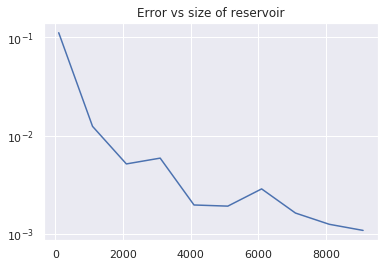

In [24]:
plt.semilogy(n_res_range, error_kura_asin.numpy())
plt.title('Error vs size of reservoir');

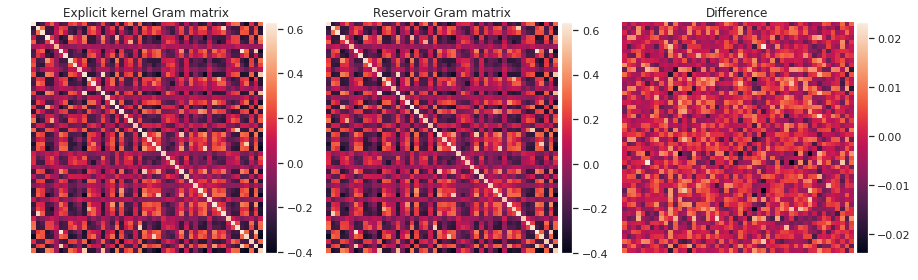

In [25]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
_, axes  = plt.subplots(1, 3, figsize=(15, 6))

plot = axes[0].imshow(K.cpu().numpy())
axes[0].axis("off")
axes[0].set_title("Explicit kernel Gram matrix")
divider = make_axes_locatable(axes[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(plot, cax=cax)

plot = axes[1].imshow(K_hat.cpu().numpy())
axes[1].axis("off")
axes[1].set_title("Reservoir Gram matrix")
divider = make_axes_locatable(axes[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(plot, cax=cax)

plot = axes[2].imshow((K-K_hat).cpu().numpy())
axes[2].axis("off")
axes[2].set_title("Difference")
divider = make_axes_locatable(axes[2])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(plot, cax=cax);

In [26]:
#rbf kernel

n_input = 50 # number of time series
input_len = 40 # time steps t
input_dim = 100 #dimension of the time series
scale_in = 1  # variance of input
scale_res = 1 # variance of reservoir

input_data = torch.zeros(n_input, input_len, input_dim).to(device)
for n_inp in range(n_input):
    input_data[n_inp,:,:] = torch.Tensor(kuramoto(input_dim, input_len))/np.sqrt(input_dim)
loss = torch.nn.MSELoss()

n_res_range = np.arange(start=100,stop=10000, step=1000)
error_kura_rbf = torch.zeros(len(n_res_range))

for i, n_res in tqdm(enumerate(n_res_range)):
    initial_state = torch.randn(n_res).to(device) / np.sqrt(n_res)
    K = compute_rbf_kernel(input_data, initial_state, scale_res)
    X_final = torch.zeros((n_input,n_res)).to(device)
    torch.manual_seed(i)
    bias = torch.Tensor(np.random.uniform(0,2*np.pi, size=n_res)).to(device)
    
    for n_in in range(n_input):
        model = ESN(input_dim, reservoir_size=n_res, bias = bias,scale_res = scale_res,\
                    scale_in = scale_in, \
                    f='cos_rbf')
        X = model.forward(input_data[n_in,:,:].reshape(input_len,input_dim), initial_state = initial_state).to(device)
        X_final[n_in,:] = X[-1,:]
    
    K_hat = torch.matmul(X_final,X_final.t())
    error_kura_rbf[i] = loss(K_hat,K) / loss(K, torch.zeros(n_input, n_input).to(device))

10it [02:11, 23.60s/it]


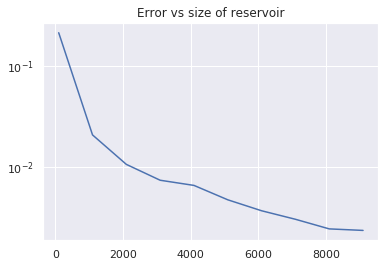

In [27]:
plt.semilogy(n_res_range, error_kura_rbf.numpy())
plt.title('Error vs size of reservoir');

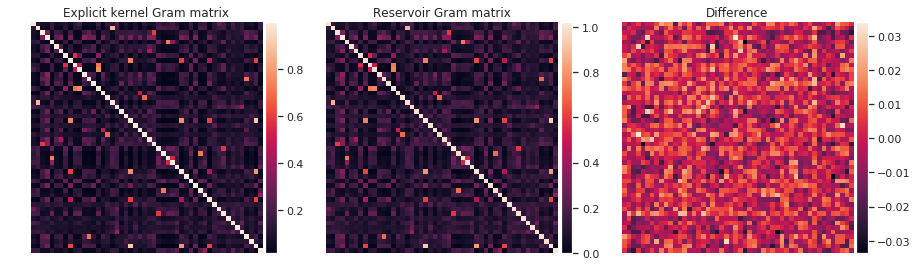

In [28]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
_, axes  = plt.subplots(1, 3, figsize=(15, 6))

plot = axes[0].imshow(K.cpu().numpy())
axes[0].axis("off")
axes[0].set_title("Explicit kernel Gram matrix")
divider = make_axes_locatable(axes[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(plot, cax=cax)

plot = axes[1].imshow(K_hat.cpu().numpy())
axes[1].axis("off")
axes[1].set_title("Reservoir Gram matrix")
divider = make_axes_locatable(axes[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(plot, cax=cax)

plot = axes[2].imshow((K-K_hat).cpu().numpy())
axes[2].axis("off")
axes[2].set_title("Difference")
divider = make_axes_locatable(axes[2])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(plot, cax=cax);

In [29]:
#heaviside
#arcsin kernel

n_input = 50 # number of time series
input_len = 40 # time steps t
input_dim = 100 #dimension of the time series
scale_in = 1  # variance of input
scale_res = 1 # variance of reservoir

input_data = torch.zeros(n_input, input_len, input_dim).to(device)
for n_inp in range(n_input):
    input_data[n_inp,:,:] = torch.Tensor(kuramoto(input_dim, input_len))/np.sqrt(input_dim)

loss = torch.nn.MSELoss()

n_res_range = np.arange(start=100,stop=10000, step=1000)
error_kura_acos_heaviside = torch.zeros(len(n_res_range))

for i, n_res in tqdm(enumerate(n_res_range)):
    initial_state = torch.randn(n_res).to(device) / np.sqrt(n_res)
    K = compute_acos_heaviside_kernel(input_data, initial_state, scale_res)
    X_final = torch.zeros((n_input,n_res)).to(device)
    for n_in in range(n_input):
        model = ESN(input_dim, reservoir_size=n_res, scale_res = scale_res, scale_in = scale_in,f='heaviside')
        X = model.forward(input_data[n_in,:,:].reshape(input_len,input_dim), initial_state = initial_state).to(device)
        X_final[n_in,:] = X[-1,:]
    
    K_hat = torch.matmul(X_final,X_final.t())
    error_kura_acos_heaviside[i] = loss(K_hat,K) / loss(K, torch.zeros(n_input, n_input).to(device))

10it [02:11, 23.54s/it]


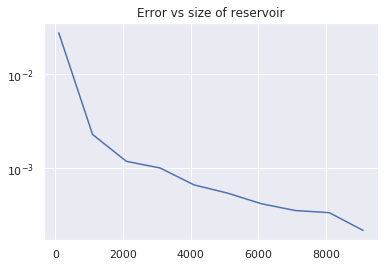

In [30]:
plt.semilogy(n_res_range, error_kura_acos_heaviside.numpy())
plt.title('Error vs size of reservoir');

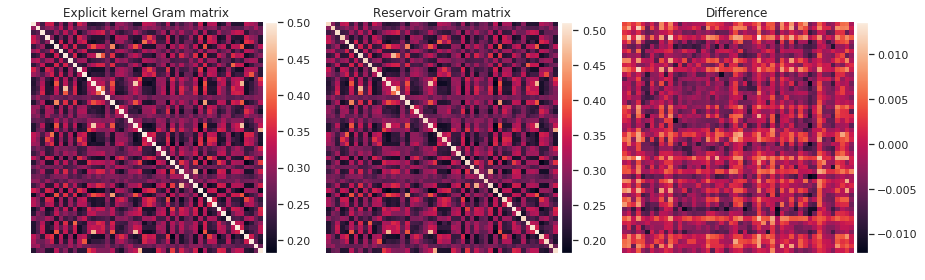

In [31]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
_, axes  = plt.subplots(1, 3, figsize=(15, 6))

plot = axes[0].imshow(K.cpu().numpy())
axes[0].axis("off")
axes[0].set_title("Explicit kernel Gram matrix")
divider = make_axes_locatable(axes[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(plot, cax=cax)

plot = axes[1].imshow(K_hat.cpu().numpy())
axes[1].axis("off")
axes[1].set_title("Reservoir Gram matrix")
divider = make_axes_locatable(axes[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(plot, cax=cax)

plot = axes[2].imshow((K-K_hat).cpu().numpy())
axes[2].axis("off")
axes[2].set_title("Difference")
divider = make_axes_locatable(axes[2])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(plot, cax=cax);

In [32]:
#asin_sign kernel

n_input = 50 # number of time series
input_len = 40 # time steps t
input_dim = 100 #dimension of the time series
scale_in = 1  # variance of input
scale_res = 1 # variance of reservoir

input_data = torch.zeros(n_input, input_len, input_dim).to(device)
for n_inp in range(n_input):
    input_data[n_inp,:,:] = torch.Tensor(kuramoto(input_dim, input_len))/np.sqrt(input_dim)

loss = torch.nn.MSELoss()

n_res_range = np.arange(start=100,stop=10000, step=1000)
error_kura_asin_sign = torch.zeros(len(n_res_range))

for i, n_res in tqdm(enumerate(n_res_range)):
    initial_state = torch.randn(n_res).to(device) / np.sqrt(n_res)
    K = compute_asin_sign_kernel(input_data, initial_state, scale_res)
    X_final = torch.zeros((n_input,n_res)).to(device)
    for n_in in range(n_input):
        model = ESN(input_dim, reservoir_size=n_res, scale_res = scale_res, scale_in = scale_in, f='sign')
        X = model.forward(input_data[n_in,:,:].reshape(input_len,input_dim), initial_state = initial_state).to(device)
        X_final[n_in,:] = X[-1,:]
    
    K_hat = torch.matmul(X_final,X_final.t())
    error_kura_asin_sign[i] = loss(K_hat,K) / loss(K, torch.zeros(n_input, n_input).to(device))

10it [02:11, 23.54s/it]


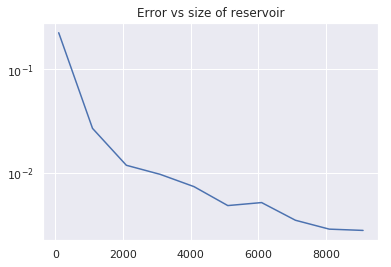

In [33]:
plt.semilogy(n_res_range, error_kura_asin_sign.numpy())
plt.title('Error vs size of reservoir');

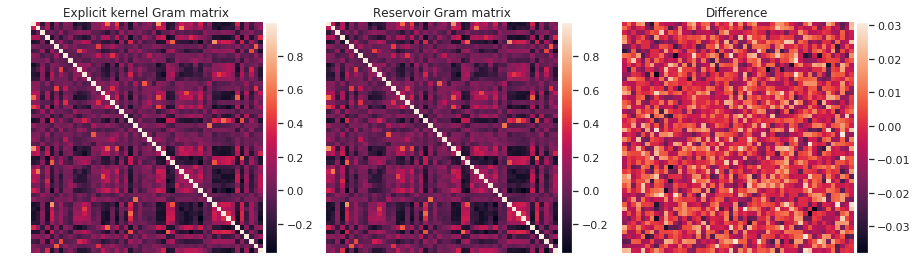

In [34]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
_, axes  = plt.subplots(1, 3, figsize=(15, 6))

plot = axes[0].imshow(K.cpu().numpy())
axes[0].axis("off")
axes[0].set_title("Explicit kernel Gram matrix")
divider = make_axes_locatable(axes[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(plot, cax=cax)

plot = axes[1].imshow(K_hat.cpu().numpy())
axes[1].axis("off")
axes[1].set_title("Reservoir Gram matrix")
divider = make_axes_locatable(axes[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(plot, cax=cax)

plot = axes[2].imshow((K-K_hat).cpu().numpy())
axes[2].axis("off")
axes[2].set_title("Difference")
divider = make_axes_locatable(axes[2])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(plot, cax=cax);

In [81]:
!nvidia-smi

Mon May 11 15:16:18 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.40.04    Driver Version: 418.40.04    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:19:00.0 Off |                    0 |
| N/A   51C    P0    33W / 250W |  15431MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  